# Problem Formulation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation

C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:
dike_model, planning_steps = get_model_for_problem_formulation(5)

In [ ]:
# start = time.time()
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=200, policies=50)
    
# end = time.time()

# print('Total run time:{} min'.format((end - start)/60))

In [ ]:
# # Write results to file again
# import pickle

# with open('Outcomes/200Scenarios50Policies.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
# # Read in results again
# import pickle

# with open('Outcomes/200Scenarios50Policies.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
# # Do the same thing but Jan's way (slower)
# from ema_workbench.util import utilities

# utilities.save_results(results, 'Outcomes/200Scenarios50Policies.csv')

In [5]:
results = utilities.load_results('Outcomes/200Scenarios50Policies.csv')

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\epa1361_open\final assignment\Outcomes\200Scenarios50Policies.csv


In [6]:
experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,26.0,308.560347,1.5,0.040640,94.864757,1.5,0.388750,324.442213,1.0,0.273762,...,4.049237e+08,0.0,0.0,2.137888e+09,0.0,0.0,9.712712e+08,0.0,377300000.0,0.0
1,58.0,113.145318,1.0,0.873360,31.275990,10.0,0.239393,166.383414,1.0,0.532549,...,4.049237e+08,0.0,0.0,2.137888e+09,0.0,0.0,9.712712e+08,0.0,377300000.0,0.0
2,24.0,92.660114,10.0,0.519441,316.880074,10.0,0.983236,285.521160,1.5,0.969825,...,4.049237e+08,0.0,0.0,2.137888e+09,0.0,0.0,9.712712e+08,0.0,377300000.0,0.0
3,122.0,304.638762,1.0,0.387266,32.107645,1.0,0.317684,102.327925,10.0,0.427642,...,4.049237e+08,0.0,0.0,2.137888e+09,0.0,0.0,9.712712e+08,0.0,377300000.0,0.0
4,38.0,106.177684,1.0,0.676617,335.572782,1.0,0.400639,218.834865,1.5,0.659950,...,4.049237e+08,0.0,0.0,2.137888e+09,0.0,0.0,9.712712e+08,0.0,377300000.0,0.0


In [7]:
# Changes so that the dataframe is fit for mathematical opertions
results = results.drop(columns="model")
results = results.apply(pd.to_numeric)


# Get the mean for all the results across the scenarios to have a quick look at significant locations
sum_results = results.apply(np.mean, axis = 0)

In [ ]:
# CODE I MIGHT NEED AGAIN

# l = []

# for i in sum_results.items():
#     if("Expected Annual Damage" in i[0]):
#         l.append(i)
        
# df_exp_dmg = pd.DataFrame(l).T
# df_exp_dmg = df_exp_dmg.rename(columns=df_exp_dmg.iloc[0])
# df_exp_dmg = df_exp_dmg.reindex(df_exp_dmg.index.drop(0))

# df_exp_dmg.apply(pd.to_numeric).plot(x = df_exp_dmg.columns, y = df_exp_dmg, kind = "scatter")
# df_exp_dmg

# locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
# df_exp_dmg["subset"] = np.select([df_exp_dmg.columns.str.contains("A.1"), df_exp_dmg.columns.str.contains("A.2"),
#               df_exp_dmg.columns.str.contains("A.3"), df_exp_dmg.columns.str.contains("A.4"),
#               df_exp_dmg.columns.str.contains("A.5")], locations)

# # for color, label in zip('bgrm', [0, 1, 2, -1]):
# #     print(color)
# #     print(df_exp_dmg[df_exp_dmg.subset == label])

In [8]:
# https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1.1, 1)) # Improvement to change legend position

No handles with labels found to put in legend.


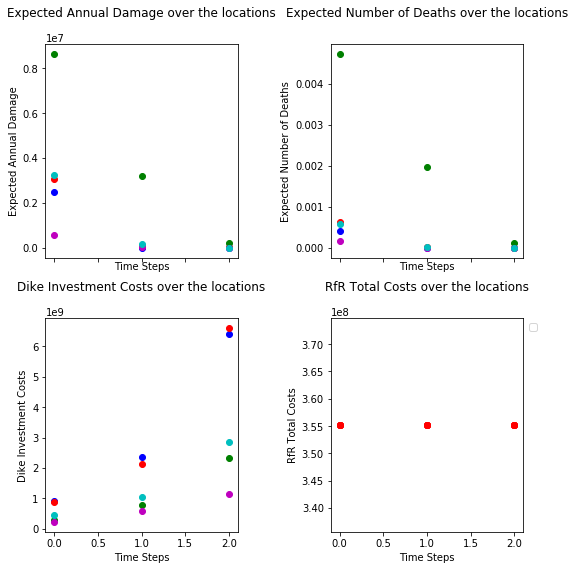

In [12]:
locations = ["A.1", "A.2", "A.3", "A.4", "A.5"]
outcomes = ["Expected Annual Damage", "Expected Number of Deaths", "Dike Investment Costs", "RfR Total Costs"]
x = [0, 1, 2]

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8), sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

for ax, criteria in zip(axes, outcomes):
    for step in x:
        for place in locations:
            if criteria == "RfR Total Costs":
                ax.plot(step, sum_results[[str(criteria) + " " + str(step)]].values[0], 'ro')
            else:
                if place == "A.1":
                    ax.plot(step, sum_results[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                            'ro', c="b", label = "A.1")
                elif place == "A.2":
                    ax.plot(step, sum_results[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                            'ro', c="r", label = "A.2")
                elif place == "A.3":
                    ax.plot(step, sum_results[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                            'ro', c="g", label = "A.3")
                elif place == "A.4":
                    ax.plot(step, sum_results[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                            'ro', c="m", label = "A.4")
                elif place == "A.5":
                    ax.plot(step, sum_results[[str(place) + "_" + str(criteria) + " " + str(step)]].values[0], 
                            'ro', c="c", label = "A.5")
                       
    ax.set_xlabel("Time Steps")
    ax.set_ylabel(criteria)
    ax.set_title(str(criteria) + " over the locations", y = 1.1)
        
legend_without_duplicate_labels(ax)
plt.tight_layout()
plt.show()

In [ ]:
# # Highest expected annual damage at timestep 0 across locations

# fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
#                         sharex=True)
# axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

# n = 3 # Time Steps

# for i in range(n):
    
#     # FIX NEEDED: to use ax.plot otherwise it will only display the last one!
#     ax = sum_results[['A.1_Expected Annual Damage ' + str(i),'A.2_Expected Annual Damage ' + str(i), "A.3_Expected Annual Damage " + str(i),
#             "A.4_Expected Annual Damage " + str(i), "A.5_Expected Annual Damage " + str(i)]].plot(kind='bar', title ="Annual Damages per Location", legend=True)
    
#     ax.set_xlabel("Location")
#     ax.set_ylabel("Annual Damages")


# plt.tight_layout()
# plt.show()

In [ ]:
for policies in dike_model.outcomes:
    print(repr(policies))

In [ ]:
# utilities.experiments_to_scenarios(results[0]) # --> Just playing; this doesn't seem to work.

In [ ]:
for policies in dike_model.levers:
    print(repr(policies))
    
levers = copy.deepcopy(dike_model.levers)

In [ ]:
for unc in dike_model.uncertainties:
    print(repr(unc))

In [ ]:
dike_model.uncertainties = [CategoricalParameter('discount rate 0', [0, 1, 2, 3], default = 2),
                CategoricalParameter('discount rate 1', [0, 1, 2, 3], default = 2),
                CategoricalParameter('discount rate 2', [0, 1, 2, 3], default = 2),
                IntegerParameter('A.0_ID flood wave shape', 0, 132, default = 50),
                RealParameter('A.1_Bmax', 30, 350, default = 200),
                RealParameter('A.1_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.1_Brate', [0, 1, 2], default = 1),
                RealParameter('A.2_Bmax', 30, 350, default = 200),
                RealParameter('A.2_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.2_Brate', [0, 1, 2], default = 1),
                RealParameter('A.3_Bmax', 30, 350, default = 200),
                RealParameter('A.3_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.3_Brate', [0, 1, 2], default = 1),
                RealParameter('A.4_Bmax', 30, 350, default = 200),
                RealParameter('A.4_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.4_Brate', [0, 1, 2], default = 1),
                RealParameter('A.5_Bmax', 30, 350, default = 200),
                RealParameter('A.5_pfail', 0, 1, default = 0.5),
                CategoricalParameter('A.5_Brate', [0, 1, 2], default = 1)]

In [ ]:
# for unc in dike_model.uncertainties:
#     print(repr(unc))
    
# uncertainties = copy.deepcopy(dike_model.uncertainties)

# for policies in dike_model.levers:
#     print(repr(policies))
    
# levers = copy.deepcopy(dike_model.levers)

# for outcome in dike_model.outcomes:
#     print(repr(outcome))
    
# outcomes = copy.deepcopy(dike_model.outcomes)

In [ ]:
# # Save results to save computational time while in dev
# import pickle

# with open('Outcomes/1000Scenarios10Policies.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [ ]:
# Read in results again
import pickle

with open('Outcomes/1000Scenarios10Policies.pkl', 'rb') as f:
    results = pickle.load(f)

results = results

In [ ]:
results

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=5000, searchover="levers", epsilons=[0.1]*len(dike_model.outcomes))

In [ ]:
# Save results to save computational time while in dev
import pickle

with open('Outcomes/Optimize5000nfe0.1epsilons.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
results.iloc[0, :33]

In [ ]:
results

In [ ]:
# # Save results to save computational time while in dev
# import pickle

# with open('Outcomes/Experiments200Scen4PolMCSamp.pkl', 'wb') as f:
#     pickle.dump(results, f)
    
# # Read in results again
# import pickle

# with open('data/Outcomes/Experiments200Scen4PolMCSamp.pkl', 'rb') as f:
#     results = pickle.load(f)

# experiments, outcomes = results

In [ ]:
# # Trying to change some of the levers / uncertainties to increase computational power

# def problem_formulation_actor():
   
#     # Load the model:
#     function = DikeNetwork()
#     # workbench model:
#     model = Model('dikesnet', function=function)
#     # Outcomes are all costs, thus they have to minimized:
#     direction = ScalarOutcome.MINIMIZE
    
#     model.uncertainties = uncertainties
#     model.outcomes = outcomes
    
    
#     # Range of dike heightening:
#     # CHANGE: Dike increase in steps of 5 decimeters, so the options are 0 (0 dm), 1 (5dm), 2(10dm)
#     # self.dh in dike_model_function.py changed to 0.5 -> Reduce computation power.
#     # CANCELLED
#     dike_lev = {'DikeIncrease': [0, 2]} 
    
#     # Series of five Room for the River projects:
#     rfr_lev = ['{}_RfR'.format(project_id) for project_id in range(0, 5)]

#     # Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
#     EWS_lev = {'EWS_DaysToThreat': [0, 4]}  # days
    
#     levers = []
    
#     # RfR levers can be either 0 (not implemented) or 1 (implemented)
#     for lev_name in rfr_lev:
#         for n in function.planning_steps:
#             lev_name_ = '{} {}'.format(lev_name, n)
#             levers.append(IntegerParameter(lev_name_, 0, 1))

#     # Early Warning System lever
#     for lev_name in EWS_lev.keys():
#         levers.append(IntegerParameter(lev_name, EWS_lev[lev_name][0],
#                                        EWS_lev[lev_name][1]))
        
#     for dike in function.dikelist:
#         # location-related levers in the form: locationName_leversName
#         for lev_name in dike_lev.keys():
#             for n in function.planning_steps:
#                 name = "{}_{} {}".format(dike, lev_name, n)
#                 levers.append(IntegerParameter(name, dike_lev[lev_name][0],
#                                            dike_lev[lev_name][1]))
        

#     model.levers = levers
#     return model


# model = problem_formulation_actor()

# for policies in model.levers:
#     print(repr(policies))